# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [2]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython', '/home/rgadea/lmfit-py/']


## Vamos introducir los datos de petalo preprocesados en matlab


In [ ]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo_fil1')
conjunto_datos.shape
print (conjunto_datos[:10,6:26])

In [3]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_trA=np.zeros((X_train.shape[0]*L1A,input_output_dim_A))
for i in range(x_train.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_train[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_trA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_trainA = datos_trA;

datos_testA=np.zeros((X_test.shape[0]*L1A,input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_testA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_testA = datos_testA;





print(x_trainA.shape)
print(x_testA.shape)


datos_trB=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_trB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_trB;

datos_testB=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_testB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_testB;





print(x_trainB.shape)
print(x_testB.shape)


50000
conjunto_datos shape: (50000, 3517)
5000
40000
5000
(25000, 600)
(25000, 600)
(5000, 500)
(5000, 500)


## Network parameters:

In [4]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
hidden_size=1200
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dimA = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgA = Input(shape=(img_rows*img_colsA,))

# "encoded" is the encoded representation of the input
encodedA = Dense(encoding_dimA, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgA)
# "decoded" is the lossy reconstruction of the input
decodedA = Dense(img_colsA*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedA)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderA = Model(input_imgA, decodedA)

encoding_dimB = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgB = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encodedB = Dense(encoding_dimB, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgB)
# "decoded" is the lossy reconstruction of the input
decodedB = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedB)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_imgB, decodedB)

## Prepare data into training and test set.

In [5]:
x_trainA = x_trainA.reshape(x_trainA.shape[0], img_colsA, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testA = x_testA.reshape(x_testA.shape[0], img_colsA, img_rows,1)


input_shapeA = (img_colsA, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
x_trainA = x_trainA.astype('float32')
# X_val= X_val.astype('float32')
x_testA = x_testA.astype('float32')

print('X_train shape:', x_trainA.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainA
X_test=x_testA

X_train shape: (25000, 30, 20, 1)


Display 20 random training images using image

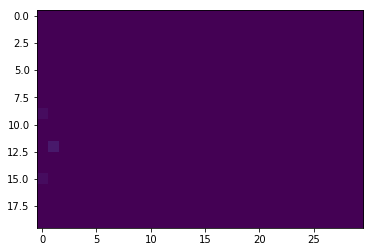

23829


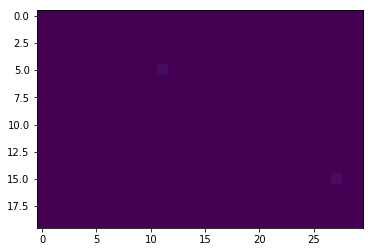

18935


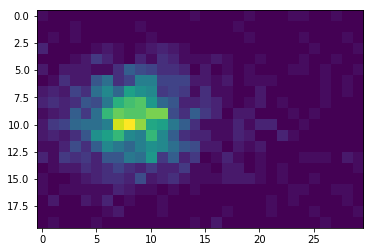

18455


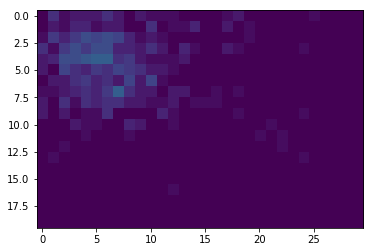

22559


In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsA]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(25000, 600)
(25000, 600)


In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[20413])
# print(x_train_scaled[20413])
# print(x_test[20413])
# print(x_test_scaled[20413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [10]:
import keras.backend as KK
import keras.callbacks as KKcall

In [11]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [12]:
# this model maps an input to its encoded representation
encoderA = Model(input_imgA, encodedA)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputA = Input(shape=(encoding_dimA,))
# retrieve the last layer of the autoencoder model
decoder_layerA = autoencoderA.layers[-1]
# create the decoder model
decoderA = Model(encoded_inputA, decoder_layerA(encoded_inputA))

autoencoderA.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderA.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [13]:
algoritmo='RMSprop'
experimento="scaledA_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimA,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderA.fit(x_train_scaled, x_train_scaled,
                epochs=100,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 3s 118us/step - loss: 17.1164 - energy_error: -35.2954 - val_loss: 19.0995 - val_energy_error: -32.3063
Epoch 2/100
25000/25000 [==============================] - 1s 33us/step - loss: 16.3092 - energy_error: -29.2540 - val_loss: 18.4761 - val_energy_error: -32.2412
Epoch 3/100
25000/25000 [==============================] - 1s 31us/step - loss: 15.8023 - energy_error: -28.0908 - val_loss: 18.0598 - val_energy_error: -30.5162
Epoch 4/100
25000/25000 [==============================] - 1s 28us/step - loss: 15.4392 - energy_error: -26.0342 - val_loss: 17.7520 - val_energy_error: -29.4406
Epoch 5/100
25000/25000 [==============================] - 1s 31us/step - loss: 15.1551 - energy_error: -24.3963 - val_loss: 17.5076 - val_energy_error: -28.7973
Epoch 6/100
25000/25000 [==============================] - 1s 29us/step - loss: 14.9197 - energy_error: -23.1483 - val_loss: 17.3046 - val_

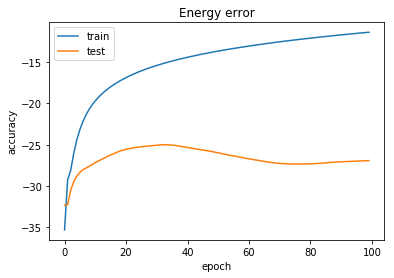

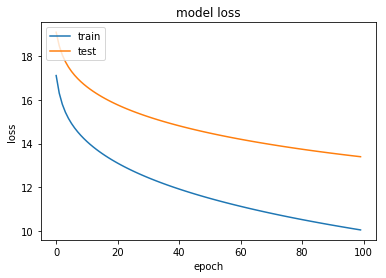

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# import pandas as pd 
# autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [16]:
autoencoderA.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimA,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [17]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [18]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderA.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


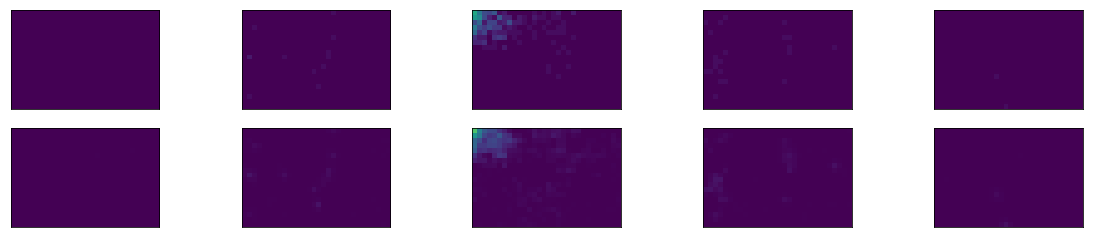

3593


In [19]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [20]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shapeB = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [21]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (5000, 25, 20, 1)


Display 20 random training images using image

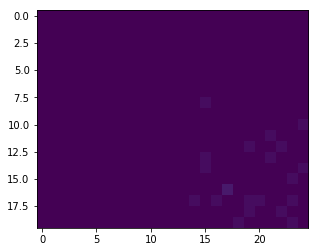

1249


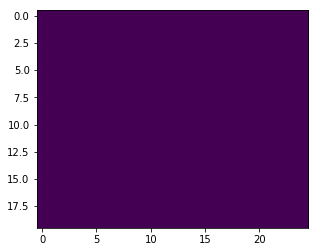

107


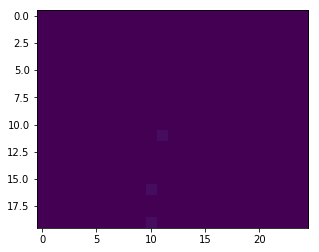

2357


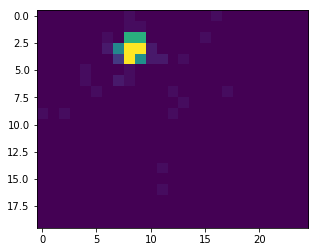

2905


In [22]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [23]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(5000, 500)
(5000, 500)


In [24]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[2413])
# print(x_train_scaled[2413])
# print(x_test[2413])
# print(x_test_scaled[2413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [25]:
import keras.backend as KK
import keras.callbacks as KKcall

In [26]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [27]:
# this model maps an input to its encoded representation
encoderB = Model(input_imgB, encodedB)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputB = Input(shape=(encoding_dimB,))
# retrieve the last layer of the autoencoder model
decoder_layerB = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_inputB, decoder_layerB(encoded_inputB))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [28]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimB,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=500,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 5000 samples, validate on 5000 samples
Epoch 1/500
5000/5000 [==============================] - 0s 71us/step - loss: 19.9154 - energy_error: -59.4498 - val_loss: 21.7483 - val_energy_error: -21.8977
Epoch 2/500
5000/5000 [==============================] - 0s 29us/step - loss: 19.5901 - energy_error: -24.5881 - val_loss: 21.5330 - val_energy_error: -17.7433
Epoch 3/500
5000/5000 [==============================] - 0s 29us/step - loss: 19.3614 - energy_error: -23.5087 - val_loss: 21.3344 - val_energy_error: -18.3250
Epoch 4/500
5000/5000 [==============================] - 0s 33us/step - loss: 19.1498 - energy_error: -23.9911 - val_loss: 21.1520 - val_energy_error: -19.1768
Epoch 5/500
5000/5000 [==============================] - 0s 29us/step - loss: 18.9552 - energy_error: -24.6678 - val_loss: 20.9855 - val_energy_error: -20.0547
Epoch 6/500
5000/5000 [==============================] - 0s 31us/step - loss: 18.7766 - energy_error: -25.3227 - val_loss: 20.8337 - val_energy_error: -

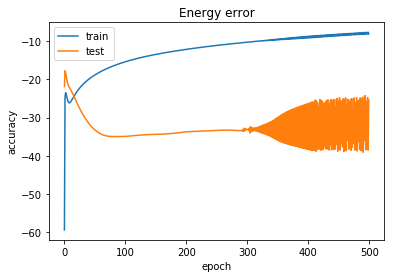

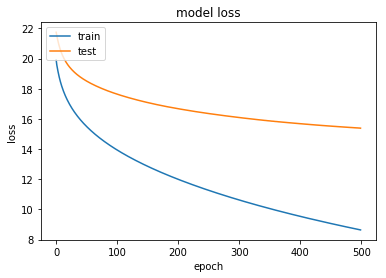

In [29]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# import pandas as pd 
# autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [31]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimB,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [32]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [33]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaledB = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaledB)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


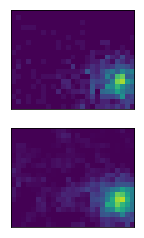

In [34]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [35]:
x_total=conjunto_datos[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)

Veamos ahora ciertos estudios

In [130]:
photodefbox2_todo_fil1= datos_matlab.get('photodefbox2_todo_fil1')
numero_muestras=photodefbox2_todo_fil1.shape[0]
x_total=photodefbox2_todo_fil1[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil1_e=np.concatenate((photodefbox2_todo_fil1,mse_idea),axis=1)
photodefbox2_todo_fil1_re=photodefbox2_todo_fil1_e
photodefbox2_todo_fil1_re[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B]=cara_externa_reconstruida
 
np.savez('../conjuntos_datos_reconstruidos/fil1_pith7mm_rad165mm_scaled2_sig_sig_1200', photodefbox2_todo_fil1_e,photodefbox2_todo_fil1_re)


In [131]:
photodefbox2_todo_fil2= datos_matlab.get('photodefbox2_todo_fil2')
numero_muestras=photodefbox2_todo_fil2.shape[0]
x_total=photodefbox2_todo_fil2[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil2_e=np.concatenate((photodefbox2_todo_fil2,mse_idea),axis=1)

photodefbox2_todo_fil2_re=photodefbox2_todo_fil2_e
photodefbox2_todo_fil2_re[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B]=cara_externa_reconstruida
 
np.savez('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200', photodefbox2_todo_fil2_e,photodefbox2_todo_fil2_re)


In [133]:
photodefbox2_todo_fil3= datos_matlab.get('photodefbox2_todo_fil3')
numero_muestras=photodefbox2_todo_fil3.shape[0]
x_total=photodefbox2_todo_fil3[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil3_e=np.concatenate((photodefbox2_todo_fil3,mse_idea),axis=1)

photodefbox2_todo_fil3_re=photodefbox2_todo_fil3_e
photodefbox2_todo_fil3_re[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B]=cara_externa_reconstruida
 
np.savez('../conjuntos_datos_reconstruidos/fil3_pith7mm_rad165mm_scaled2_sig_sig_1200', photodefbox2_todo_fil3_e,photodefbox2_todo_fil3_re)


In [132]:
photodefbox2_todo_fil4= datos_matlab.get('photodefbox2_todo_fil4')
numero_muestras=photodefbox2_todo_fil4.shape[0]
x_total=photodefbox2_todo_fil4[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil4_e=np.concatenate((photodefbox2_todo_fil4,mse_idea),axis=1)

photodefbox2_todo_fil4_re=photodefbox2_todo_fil4_e
photodefbox2_todo_fil4_re[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B]=cara_externa_reconstruida
 
np.savez('../conjuntos_datos_reconstruidos/fil4_pith7mm_rad165mm_scaled2_sig_sig_1200', photodefbox2_todo_fil4_e,photodefbox2_todo_fil4_re)


In [47]:
veamosd1 =photodefbox2_todo_fil1_e[:,-9]
# veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
veamosen1 =photodefbox2_todo_fil1_e[:,-11]
veamoser1=photodefbox2_todo_fil1_e[:,-1]

# veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
# # veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
# veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);

Veamos ahora los histogramnas 2d que nos interesan

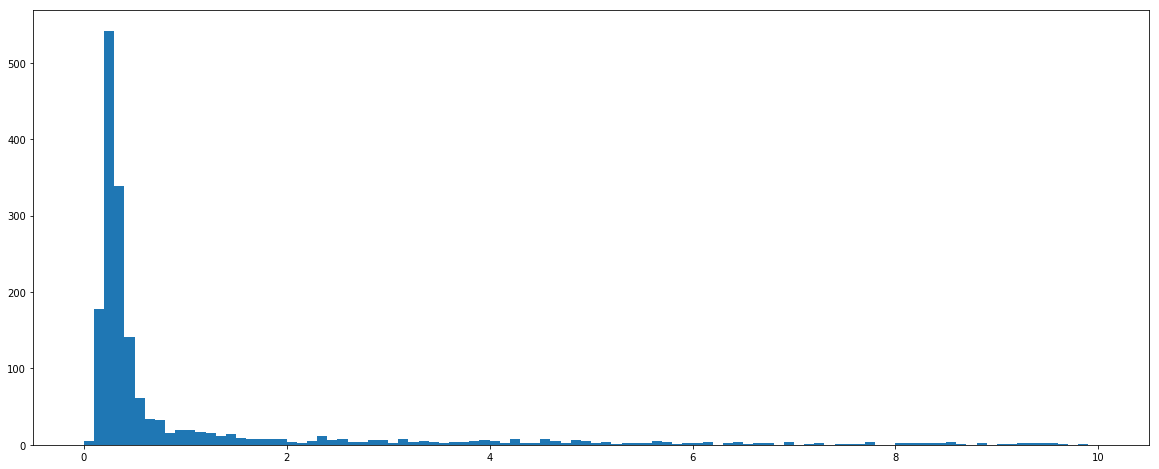

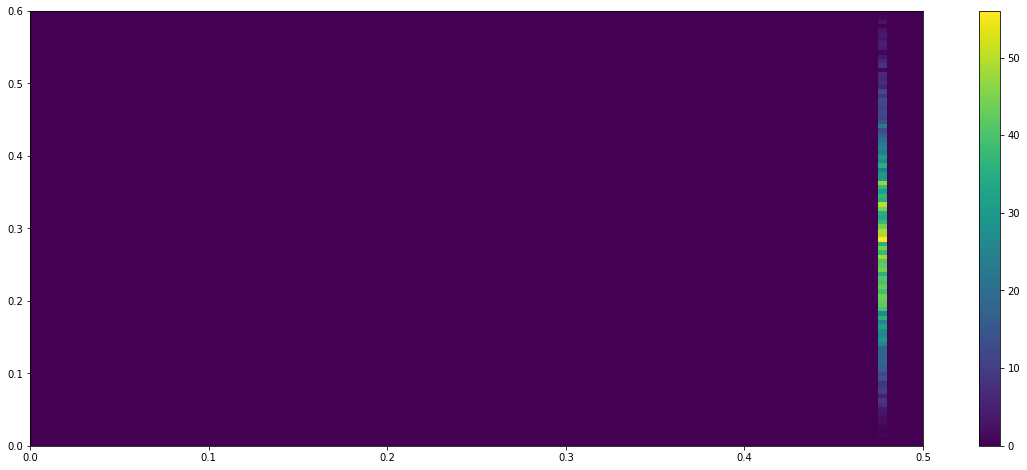

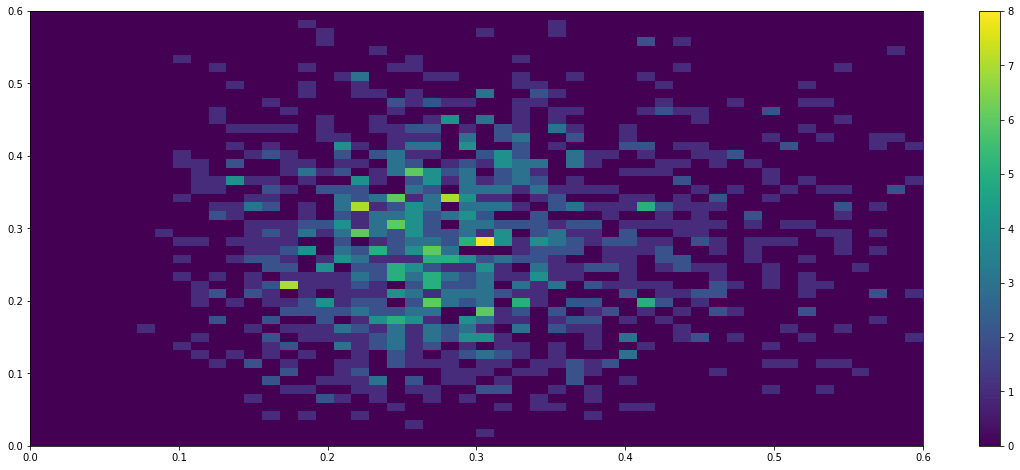

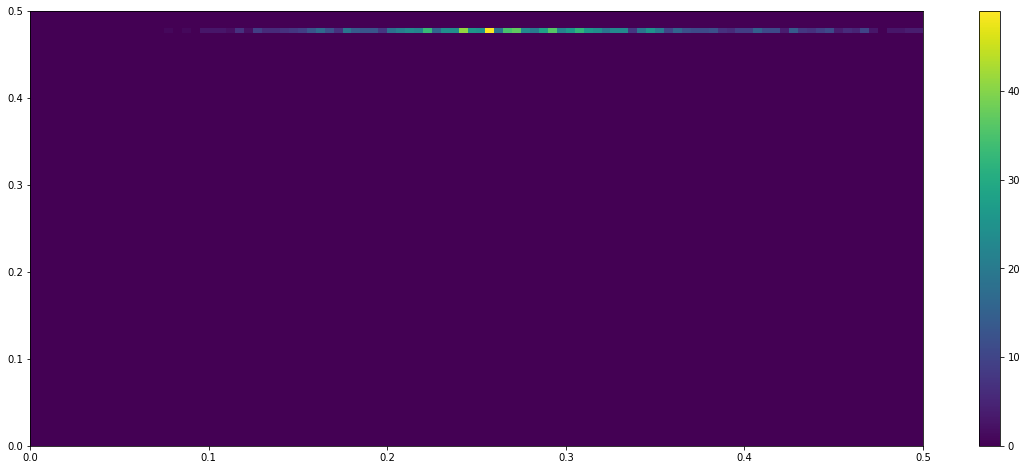

In [49]:

plt.figure(figsize=(20, 8))
plt.hist(veamoser1, bins=100, range=(0,10))

plt.figure(figsize=(20, 8))
h1=plt.hist2d(veamosen1, veamosd1, bins=100,range=[(0,0.5),(0,0.6)])
plt.colorbar(h1[3])
plt.show()

plt.show()
plt.figure(figsize=(20, 8))
h2=plt.hist2d(veamoser1,veamosd1, bins=50, range=[(0,0.6),(0,0.6)])
plt.colorbar(h2[3])
plt.show()

plt.figure(figsize=(20, 8))
h3=plt.hist2d(veamoser1,veamosen1, bins=100, range=[(0,0.5),(0,0.5)])
plt.colorbar(h3[3])
plt.show()

## Visualizamos los resultados

Visualizamos todos los sensores: 

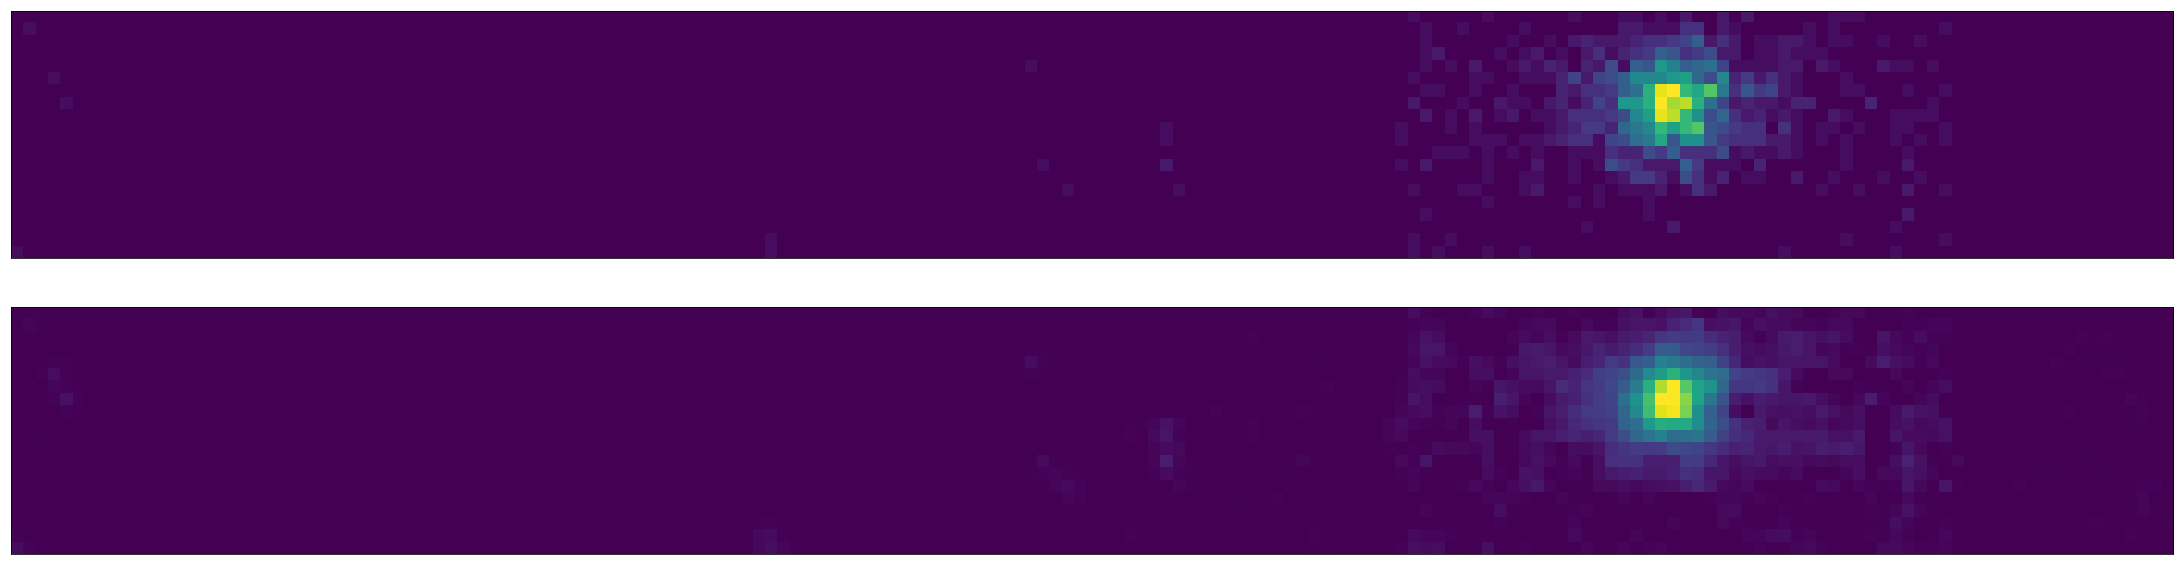

In [128]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,cara_externa.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

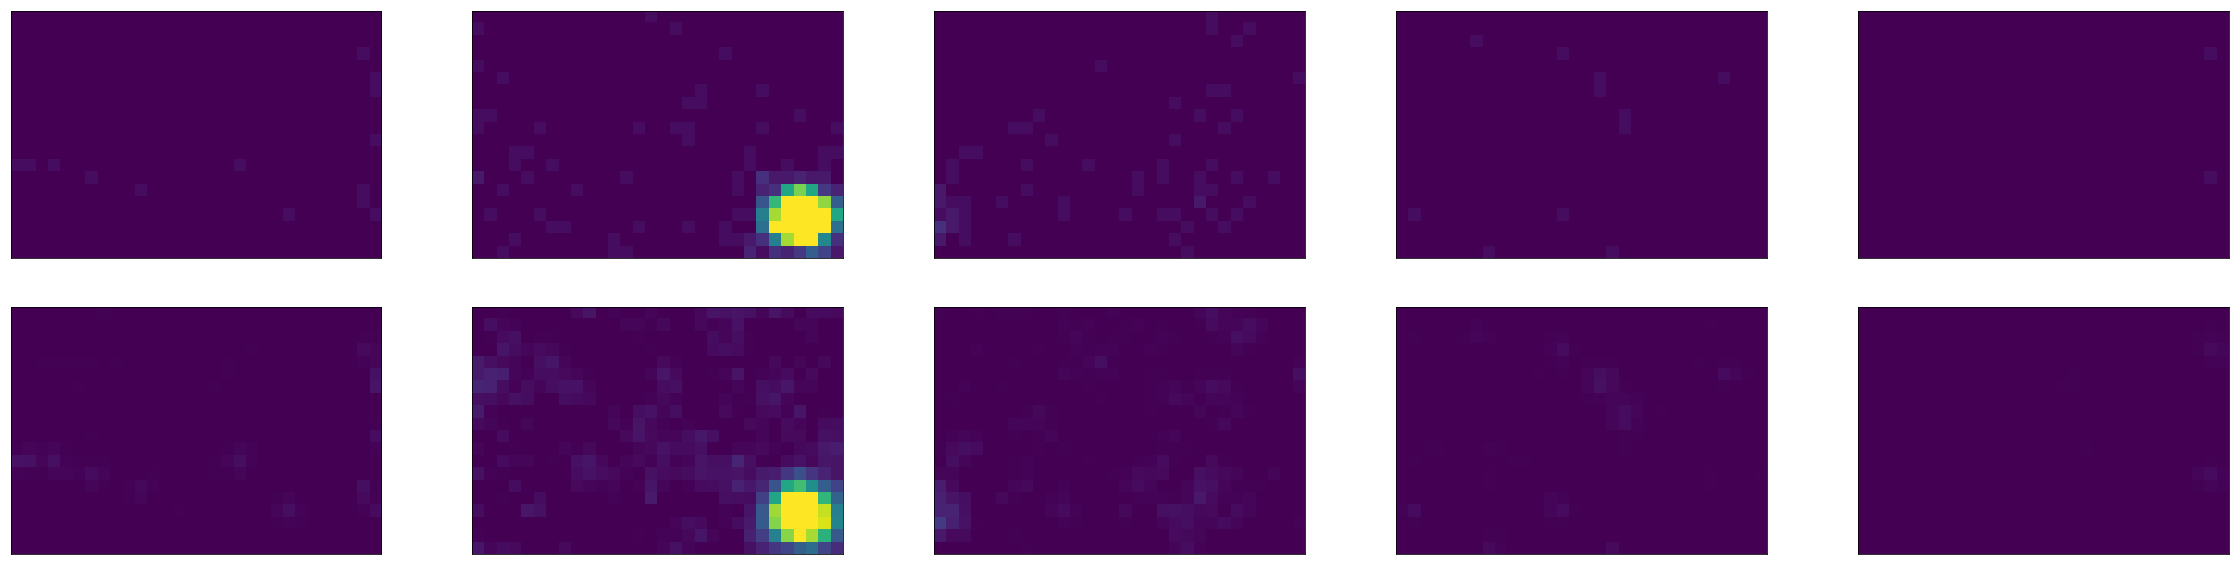

In [43]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

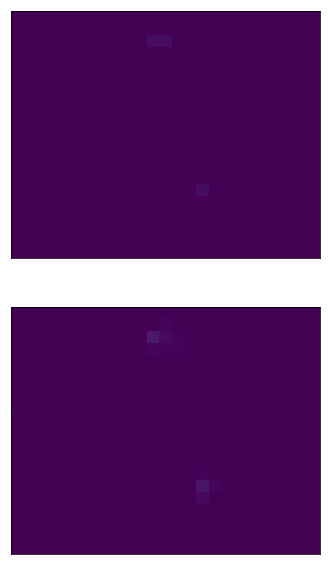

912


In [44]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [45]:
print(idea)
np.sum(cara_externa_reconstruida,axis=0)

912


array([ 7538.49503176,  8257.12317076,  9135.59883796, ...,
        9128.80539884, 10580.754189  ,  7688.20022748])

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


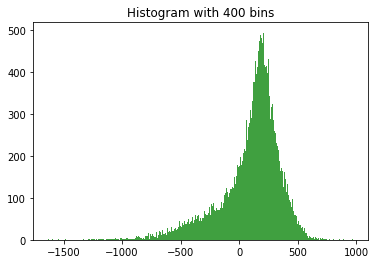

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 400
    # variables        = 3
    chi-square         = 301670.423
    reduced chi-square = 759.875120
    Akaike info crit   = 2656.25033
    Bayesian info crit = 2668.22473
[[Variables]]
    amp:  402.307117 +/- 5.26375026 (1.31%) (init = 200)
    cen:  177.864431 +/- 2.28132404 (1.28%) (init = 0)
    wid:  213.534983 +/- 3.22627939 (1.51%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



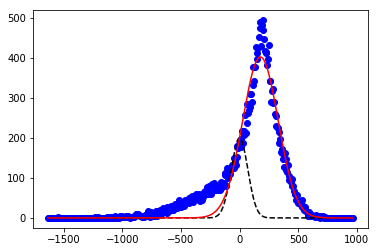

In [46]:
veamos_energia=(np.sum(cara_externa_reconstruida, axis=1))-(np.sum(cara_externa, axis=1))
n, bins, patches = plt.hist(veamos_energia, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=200, cen=0, wid=100)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()